## This script is here to show we can not do the analysis just taking the distances between the regions by activation. We need to do it by pair of regions and functional connectivity

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [28]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.stats import shapiro
from numpy.linalg import svd
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.manifold import TSNE, SpectralEmbedding,Isomap
from colorspace import sequential_hcl
%run functions-py.py

In [3]:
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [4]:
X=np.load('../../../Documentos/Mapper/Data/ts_data_2.npy')

In [5]:
X=np.swapaxes(X,0,2)

In [6]:
(s,r,t)=np.shape(X[:,:,:]) #subject,region,time
print(s,r,t)

492 268 193


In [7]:
suspense=np.load("../Data/resampled_suspense.npy")

In [8]:
file="../Data/my_rois_net1_ordered.json"

In [9]:
networks=['Salience','Frontal-Parietal','Default']
my_dict=regions_from_json(file,networks,verbose=False)
regions=my_dict['array']
lengths=my_dict['length']
r=np.sum(lengths)
print(r)

74


In [10]:
Z=X[:,regions,:]

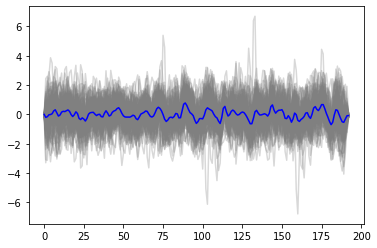

In [11]:
_=plt.plot(Z[:100,10,:].T,color='gray',alpha=0.3)
plt.plot(np.mean(Z[:100,10,:],axis=0),color='blue')

### No tiene sentido tomar el promedio de todos los sujetos pero hagamoslo por mirar qué pasa

In [32]:
M=Z[1,:,:]
#M=np.mean(Z,axis=0)
M.shape

(74, 193)

In [33]:
dist=pdist(M.T,metric='cityblock')
squareform(dist).shape

(193, 193)

In [34]:
embs={}

In [35]:
tsne=TSNE(n_components=2,metric='precomputed',perplexity=30,random_state=65)
emb=tsne.fit_transform(squareform(dist))
embs["tsne"]=emb

In [36]:
u,w,v = svd(squareform(dist))
emb=u[:,:2]
embs["svd"]=emb

In [37]:
emb,e=cmdscale(squareform(dist),2)
embs["cmds"]=emb

In [38]:
iso=Isomap(n_neighbors=20,n_components=2,metric='precomputed')
emb=iso.fit_transform(squareform(dist))
embs["iso"]=emb

In [39]:
Aff=affinity_matrix(squareform(dist),n_neighbors=20,heat_kernel=False)
if(not check_connected(Aff.toarray())):
     raise ValueError('Matrix is not connected')
else:
    se=SpectralEmbedding(n_components=2,affinity='precomputed')
    emb=se.fit_transform(Aff)
embs["se1"]=emb

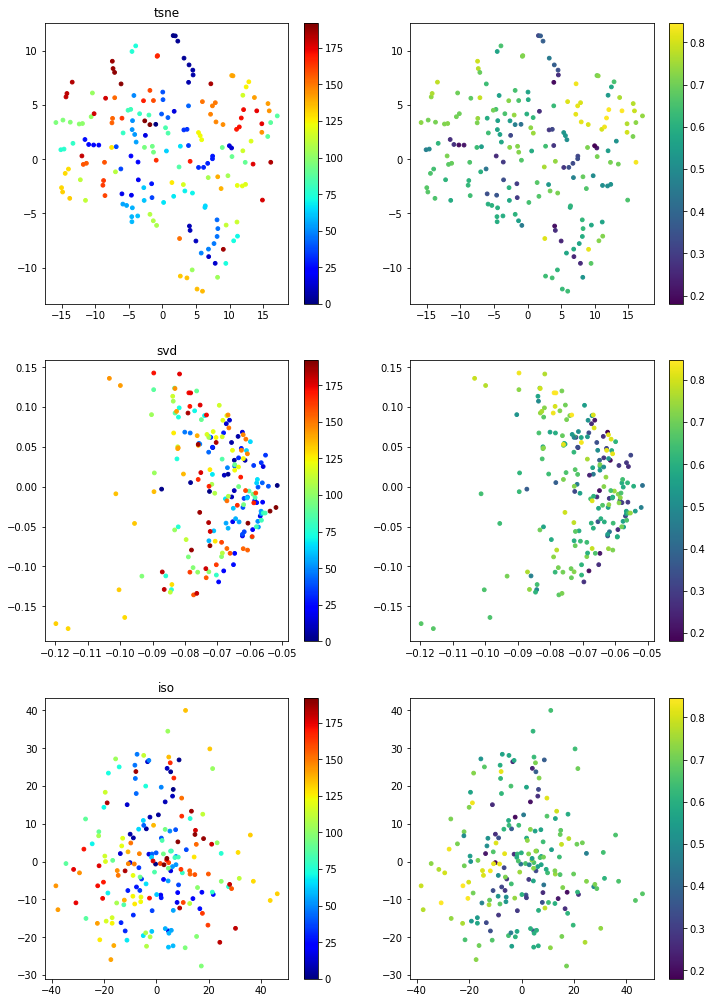

In [18]:
plt.figure(figsize=(12,30))
i=0
for key in embs.keys():
    i=i+1
    emb=embs[key]
    plt.subplot(5,2,2*i-1)
    plt.title(key)
    plt.scatter(emb[:,0],emb[:,1],s=14, c=range(t),cmap=plt.get_cmap('jet'))
    plt.colorbar()
    plt.subplot(5,2,2*i)
    plt.scatter(emb[:,0],emb[:,1],s=14, c=suspense,cmap=plt.get_cmap('viridis'))
    plt.colorbar()

[]

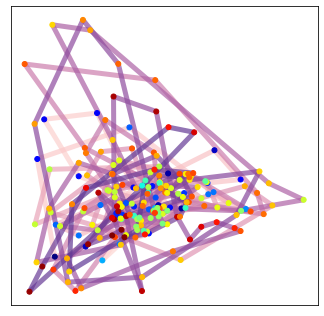

In [40]:
fig,ax = plt.subplots(figsize=(5.5,5.5))
emb=embs["iso"]
l=emb.shape[0]
#color=truncate_colormap(plt.get_cmap('Purples'),0.2,1,n=200)
#cmap=sns.color_palette("flare", as_cmap=True)
pal  = sequential_hcl("Purple-Orange", rev = True)
color=pal.cmap(300)

#line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=1,linewidth=2,zorder=1) #time-line
line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=0.7,linewidth=5,zorder=1) #time-line
im=plt.scatter(emb[:,0],emb[:,1],s=25, c=suspense,cmap=plt.get_cmap('jet')) #dots

ax.set_xticks([])
ax.set_yticks([])

fig.subplots_adjust(right=0.8,bottom=0.2)
cbar1_ax = fig.add_axes([0.82, 0.23, 0.04, 0.62]) #left, bottom, width, height
cbar1=fig.colorbar(im,cax=cbar1_ax)
cbar1.ax.set_ylabel('Level of suspense',rotation=270,fontsize=14,labelpad=20)
cbar1.set_ticks([])
cbar2_ax = fig.add_axes([0.125, 0.15, 0.67, 0.03]) #left, bottom, width, height
cbar2=fig.colorbar(line,cax=cbar2_ax,ticks=np.arange(0,176,25)/175,orientation='horizontal')
cbar2.ax.set_xlabel('States',fontsize=14,labelpad=10)
_=cbar2.ax.set_xticklabels([str(i) for i in np.arange(0,176,25)])
#fig.savefig('../Imagenes/thesis/iso_filt_alone.pdf',bbox_inches='tight') 

### Ahora tomemos el promedio pero después de formar las distancias 

In [70]:
dists=[]

In [76]:
for i in range(s):
    M=Z[i,:,:]
    dist=pdist(M.T,metric='cityblock')
    dists.append(squareform(dist))

In [93]:
#D=dists[1]
D=np.mean(np.stack(dists,axis=2),axis=2)
D.shape

(193, 193)

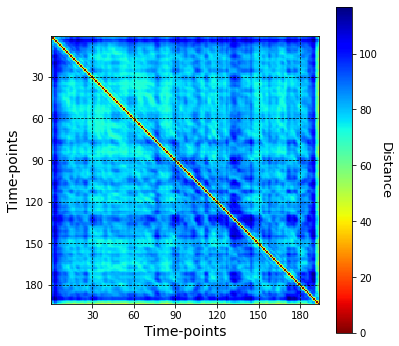

In [100]:
fig =plt.figure(figsize=(6,6))
plt.imshow(D,cmap=plt.get_cmap('jet_r'),interpolation='nearest')

plt.xlabel('Time-points',fontsize=14)
plt.ylabel('Time-points',fontsize=14)

g=30
ticks=np.arange(g-1,193+1,g)
plt.xticks(ticks=ticks,labels=ticks+1)
plt.yticks(ticks=ticks,labels=ticks+1)

cbar=plt.colorbar()
cbar.ax.set_ylabel('Distance',rotation=270,fontsize=13,labelpad=14)


#for i in [28,40,60,78,113,145]:
for i in ticks[0:7]:
    plt.axvline(x=i,color='black',linestyle='dashed',linewidth=0.7)
    plt.axhline(y=i,color='black',linestyle='dashed',linewidth=0.7)
plt.savefig('../Imagenes/thesis/all_l1-bad_dist.pdf',bbox_inches='tight')

In [95]:
embs={}

In [27]:
tsne=TSNE(n_components=2,metric='precomputed',perplexity=30,random_state=65)
emb=tsne.fit_transform(squareform(dist))
embs["tsne"]=emb

In [62]:
u,s,v = svd(squareform(dist))
emb=u[:,:2]
embs["svd"]=emb

In [39]:
emb,e=cmdscale(squareform(dist),2)
embs["cmds"]=emb

In [96]:
iso=Isomap(n_neighbors=20,n_components=2,metric='precomputed')
emb=iso.fit_transform(D)
embs["iso"]=emb

In [18]:
Aff=affinity_matrix(squareform(dist),n_neighbors=10,heat_kernel=False)
if(not check_connected(Aff.toarray())):
     raise ValueError('Matrix is not connected')
else:
    se=SpectralEmbedding(n_components=2,affinity='precomputed')
    emb=se.fit_transform(Aff)
embs["se1"]=emb

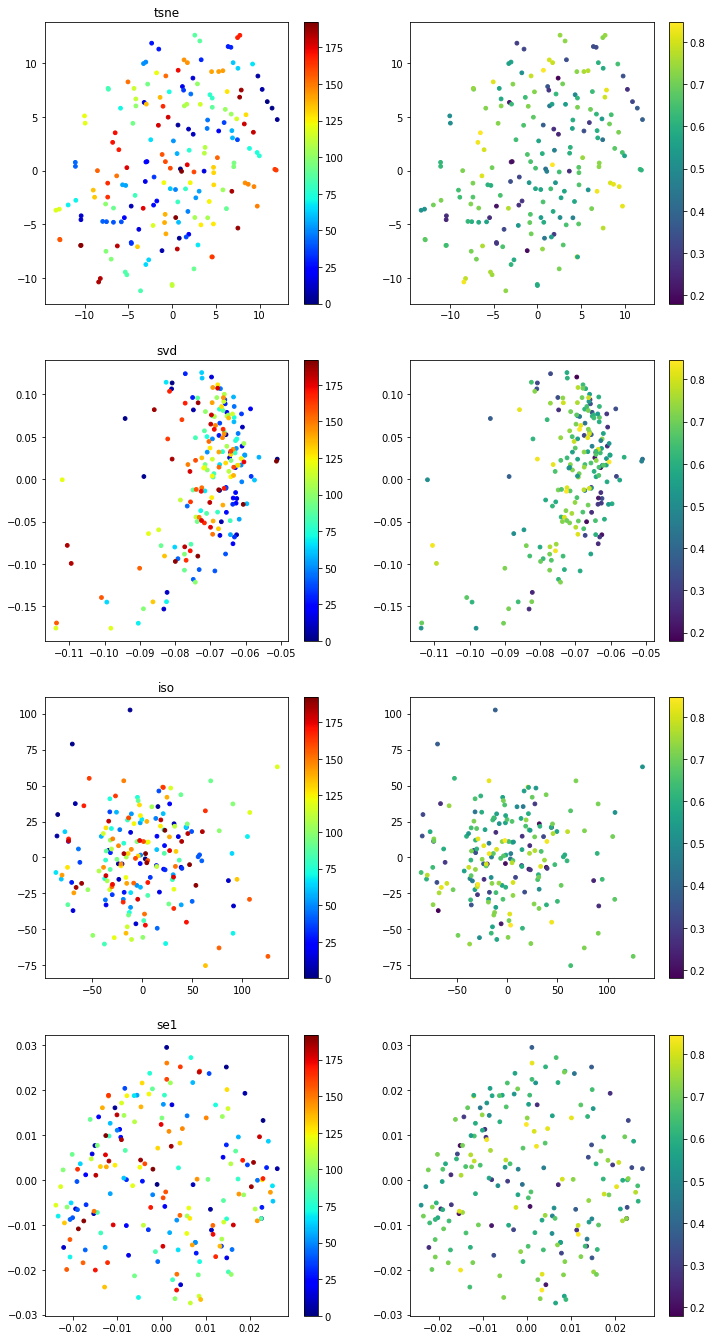

In [65]:
plt.figure(figsize=(12,30))
i=0
for key in embs.keys():
    i=i+1
    emb=embs[key]
    plt.subplot(5,2,2*i-1)
    plt.title(key)
    plt.scatter(emb[:,0],emb[:,1],s=14, c=range(t),cmap=plt.get_cmap('jet'))
    plt.colorbar()
    plt.subplot(5,2,2*i)
    plt.scatter(emb[:,0],emb[:,1],s=14, c=suspense,cmap=plt.get_cmap('viridis'))
    plt.colorbar()

[ 29  59  89 119 149 179]


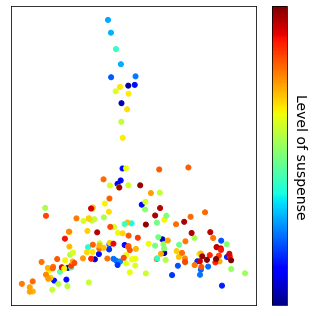

In [109]:
t=193
fig,ax = plt.subplots(figsize=(5.5,5.5))
emb=embs["iso"]
l=emb.shape[0]
#color=truncate_colormap(plt.get_cmap('Purples'),0.2,1,n=200)
#cmap=sns.color_palette("flare", as_cmap=True)
pal  = sequential_hcl("Purple-Orange", rev = True)
color=pal.cmap(300)

#line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=1,linewidth=2,zorder=1) #time-line
#line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=0.7,linewidth=5,zorder=1) #time-line
im=plt.scatter(emb[:,0],emb[:,1],s=25, c=suspense,cmap=plt.get_cmap('jet')) #dots

ax.set_xticks([])
ax.set_yticks([])

g=30
ticks=np.arange(g-1,194,g)
print(ticks)

cbar=plt.colorbar()
cbar.set_ticks([])
cbar.ax.set_ylabel('Level of suspense', rotation=270,fontsize=14,labelpad=20)
#cbar2_ax = fig.add_axes([0.15, 0.13, 0.615, 0.05]) #left, bottom, width, height

#plt.xticks(ticks=ticks,labels=ticks+1)

#cbar2=fig.colorbar(line,cax=cbar2_ax,ticks=ticks/t_s,orientation='horizontal')
#cbar2.ax.set_xlabel('States',fontsize=14,labelpad=5)
#_=cbar2.ax.set_xticklabels([str(i) for i in ticks+1])

fig.savefig('../Imagenes/thesis/l1_bad_alone.pdf',bbox_inches='tight')

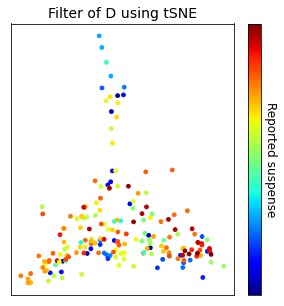

In [82]:
fig=plt.figure(figsize=(5,5))
plt.scatter(embs['iso'][:,0],embs['iso'][:,1],s=14, c=suspense,cmap=plt.get_cmap('jet'))
cbar=plt.colorbar()
cbar.set_ticks([])
cbar.ax.set_ylabel('Reported suspense', rotation=270,fontsize=12,labelpad=16)
plt.title("Filter of D using tSNE",fontsize=14)
plt.xticks([]);
plt.yticks([]);
#fig.savefig('../Imagenes/avance_3/l1_bad_alone.png',bbox_inches='tight')